<a href="https://colab.research.google.com/github/prasann25/colab/blob/main/06_transfer_learning_in_tensorflow-part3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning With TensorFlow Part 3: Scaling Up (Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101(101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training ( leveraging the power of deep learning).

Original Food101 paper : https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
# Check to see if we're using a GPU
!nvidia-smi

Mon Jul 19 03:25:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions
In previous notebooks, we've created a series of helper functions to do different tasks, let's download them



In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-19 03:25:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-19 03:25:47 (90.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper funcitons for our notebook
from helper_functions import plot_loss_curves, create_tensorboard_callback, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data
Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the `image_data_modification` notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2021-07-19 03:25:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  78.6MB/s    in 9.6s    

2021-07-19 03:25:59 (161 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"


In [6]:
# How many images/classes are there?
walk_through_dir(dir_path="101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/seaweed_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pork_chop'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macaroni_and_cheese'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hot_dog'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/falafel'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/greek_salad'.
There are 0 directories and 250 images in '1

In [7]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE= (224, 224)
BATCH_SIZE=32
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                image_size=IMG_SIZE,
                                                                                batch_size=BATCH_SIZE,
                                                                                label_mode="categorical")
# Not Shuffle the test data for prediction analysis
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes
Here are the steps we're going to take :
* Create a ModelCheckpoint callback
* Create data augmentation layer to build data augmentation right into model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model ( we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)


In [8]:
# Create  checkpoint callback

checkpoint_path="101_classes_10_percent_data_model_checkpoint"
checkpoint_callback  = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,                                                          
                                                          save_weights_only=True,
                                                          monitor="val_accuracy",
                                                          save_best_only=True,
                                                          save_freq="epoch")


In [9]:
# Create data augmentation layer to incorporate it right into the model

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
              preprocessing.RandomFlip("horizontal"),
              preprocessing.RandomRotation(0.2),
              preprocessing.RandomHeight(0.2),
              preprocessing.RandomWidth(0.2),
              preprocessing.RandomZoom(0.2),
              #preprocessing.Rescaling(1/255.), # rescale inputs of images to between 0 & 1, required for model like ResNet50              
            ], name="data_augmentation")

In [10]:
# Setup the base model and freeze its layers(this will extract features)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup  model architectures with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")

x = data_augmentation(inputs) # augment images (only happens during the training phase)

x = base_model(x, training = False) # put the base model in inference mode, so weights which need to stay frozen, stay frozen

x = layers.GlobalAvgPool2D(name="global_avg_pool_layer")(x)

# For layers, the inputs or x goes outside. For model it can go inside 
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer") (x)

model = tf.keras.Model(inputs, outputs)


16711680/16705208 [==============================] - 0s 0us/step


In [11]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [12]:
# Compile our model
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

history_all_classes_10_percent = model.fit(train_data_all_10_percent, 
                                           epochs=5, # fit for epochs to keep experiment quick
                                           validation_data = test_data,
                                           validation_steps = int(0.15 *len(test_data)), # validate on only 15% of the data during training
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 123s 371ms/step - loss: 3.4804 - accuracy: 0.2411 - val_loss: 2.6649 - val_accuracy: 0.4055
Epoch 2/5
237/237 [==============================] - 74s 311ms/step - loss: 2.3507 - accuracy: 0.4611 - val_loss: 2.2138 - val_accuracy: 0.4701
Epoch 3/5
237/237 [==============================] - 66s 278ms/step - loss: 1.9819 - accuracy: 0.5341 - val_loss: 2.0849 - val_accuracy: 0.4791
Epoch 4/5
237/237 [==============================] - 64s 267ms/step - loss: 1.7636 - accuracy: 0.5707 - val_loss: 1.9694 - val_accuracy: 0.4989
Epoch 5/5
237/237 [==============================] - 60s 252ms/step - loss: 1.6211 - accuracy: 0.6008 - val_loss: 1.9271 - val_accuracy: 0.5013


In [13]:
# Evaluate the model
model.evaluate(test_data)


790/790 [==============================] - 91s 115ms/step - loss: 1.7183 - accuracy: 0.5527


[1.7183185815811157, 0.5527128577232361]

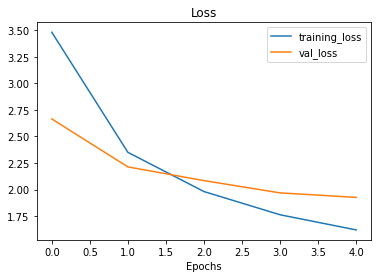

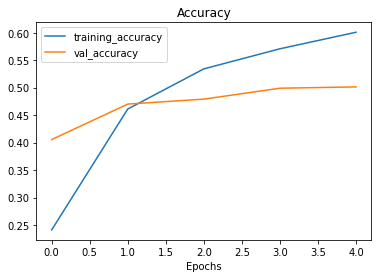

In [14]:
# Plot loss curves
plot_loss_curves(history_all_classes_10_percent)

> **Question** : What do these curves suggest? 
Hint : ideally, the two curves should be very similar to each other, it not...

> **Answer** : Our model is overfitting as seen above, val_loss and val_accuracy deviating from training curves.

## Fine-tuning

In [18]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except last 5
for layer in base_model.layers[:-5] :
  layer.trainable = False


In [ ]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10%
              metrics=["accuracy"])

In [19]:
# what layers in model are trainable ?
for layer in model.layers :
  print(layer.name, layer.trainable)


input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [20]:
# Check with layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers) :
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Fit the model with 